In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load data
og_data = pd.read_csv('../data/combined_data.csv')

# Remove very expensive rentals (1500 EUR pr night)

In [3]:
# filter out price over 1500
data = og_data[og_data['realSum'] < 1500]

# print message
removed = og_data.shape[0]-data.shape[0]
percent = removed/og_data.shape[0]
print(f'{removed} rows and {round(percent,4)}% of the data removed')


258 rows and 0.005% of the data removed


# One hot encode

In [4]:
# Look at factor variables
print(og_data['room_type'].unique())
print(og_data['city'].unique())
print(og_data['period'].unique())

['Entire home/apt' 'Private room' 'Shared room']
['Barcelona' 'Budapest' 'London' 'Vienna' 'Amsterdam' 'Paris' 'Berlin'
 'Lisbon' 'Athens' 'Rome']
['Weekdays' 'Weekends']


In [5]:
# Start by selecting only the necessary columns
filtered_data = data[['room_type', 'person_capacity', 'biz', 'bedrooms', 'dist', 'metro_dist', 'city', 'period']]

# Now apply one-hot encoding to the categorical columns 'room_type', 'city', and 'period'
one_hot_encoded_data = pd.get_dummies(filtered_data, columns=['room_type', 'city', 'period'])

# Convert all Boolean columns to integers (0 and 1)
for col in one_hot_encoded_data.columns:
    if one_hot_encoded_data[col].dtype == bool:
        one_hot_encoded_data[col] = one_hot_encoded_data[col].astype(int)

# Normalize data
scaler_norm = MinMaxScaler()
X_data_normalized = scaler_norm.fit_transform(one_hot_encoded_data)
y_data_normalized = scaler_norm.fit_transform(data.loc[:, ['realSum']])

X = X_data_normalized
y = y_data_normalized

# Split the data

In [6]:
# 15% saved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# 15% of the remaining saved for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Dummy mean model

In [7]:
performances = []

In [8]:
mean_value = y_train.mean()
model_name = 'mean'
for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# Linear model

In [9]:
reg = LinearRegression().fit(X_train, y_train)

In [10]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# KNN model

In [11]:
for k in [5,10,20,30,100]: # Choosing number of neighbors
    # Load model
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit model
    knn.fit(X_train, y_train)
    # Zip data and labels
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        # Make predictions                
        preds = knn.predict(x)
        # Get r2 score
        r2 = r2_score(y, preds)
        # 
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'KNN-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

# Plotting

In [12]:
perf_df = pd.DataFrame(performances)

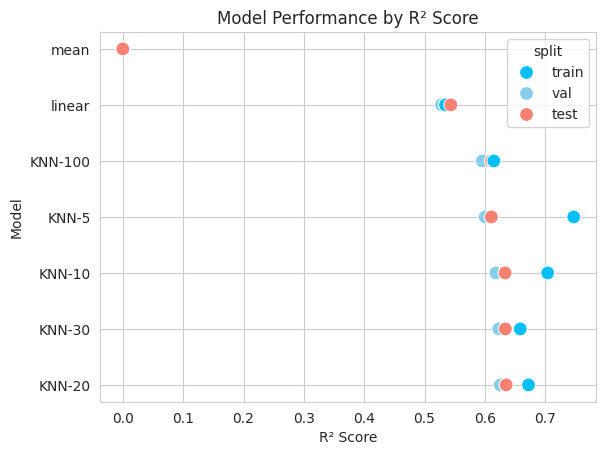

In [32]:
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                     y='model', 
                     x='r2', 
                     marker='o',   # Circle markers
                     s=100,        # Size of the markers
                     hue='split',  # Color by split
                     palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by R² Score')

# Adding x and y axis labels
plt.xlabel('R² Score')
plt.ylabel('Model')
# Save plot
plt.savefig(('../plots/base_models_R2.png'))
# Display the plot
plt.show()

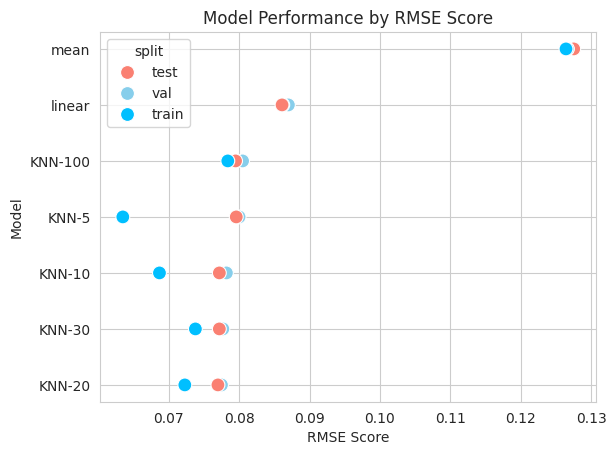

In [31]:
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                     y='model', 
                     x='rmse', 
                     marker='o',   # Circle markers
                     s=100,        # Size of the markers
                     hue='split',  # Color by split
                     palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by RMSE Score')

# Adding x and y axis labels
plt.xlabel('RMSE Score')
plt.ylabel('Model')
# Save plot
plt.savefig(('../plots/base_models_RMSE.png'))
# Display the plot
plt.show()

In [16]:
best_model = KNeighborsRegressor(n_neighbors=20)
best_model.fit(X_train, y_train)
best_preds = best_model.predict(X_val)
absolute_error = np.abs(best_preds - y_val)


In [17]:
best_preds=best_preds.flatten()
y_val=y_val.flatten()

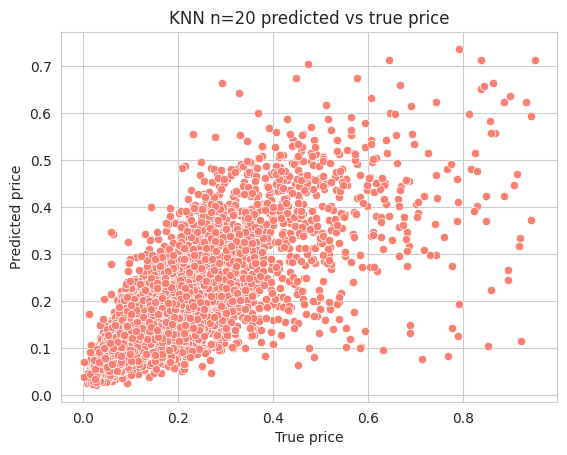

In [33]:
sns.scatterplot(x=y_val, y=best_preds, color='salmon')
plt.title('KNN n=20 predicted vs true price')
plt.xlabel('True price')
plt.ylabel('Predicted price')
# Save plot
plt.savefig(('../plots/KNN20_prdicted_true.png'))
plt.show()